In [1]:
# grader-required-cell

import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt

#### Import your dataset

Disini coba ganti setiap path sesuai path yang benernya di local kalian / di drive gimana

In [2]:
import os
import zipfile
import matplotlib.pyplot as plt
import tensorflow as tf

#Change every path to your dataset train, and test path
source_path = '/Users/arsyaninsa/Documents/Data_Personal/Kuliah/Bangkid/Nyobas Modelling/dataset_many'

source_path_train = '/Users/arsyaninsa/Documents/Data_Personal/Kuliah/Bangkid/Nyobas Modelling/dataset_many/train'
source_path_test = '/Users/arsyaninsa/Documents/Data_Personal/Kuliah/Bangkid/Nyobas Modelling/dataset_many/test'


### Prepare Pre-trained model
Download the inception model for pre-trained

In [3]:
import urllib.request

# URL ResNetV2
url = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

local_weights_file = '../pretrained/resnet_pretrained''

urllib.request.urlretrieve(url, local_weights_file)


### Generate data
Using ImageGenerator from Keras.
This function include augmentation to optimize training data image

In [4]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image, UnidentifiedImageError

def train_val_generators(train_folder, test_folder):
    """
    TRAIN VAL GENERATORS
    """
    # Set the image
    img_size = (150, 150)

    # Instantiate the ImageDataGenerator class
    # augmenting the images
    train_datagen = ImageDataGenerator(
        rescale=1./255.,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    validation_datagen = ImageDataGenerator(rescale=1./255.)

    # Load training images and labels
    train_generator = train_datagen.flow_from_directory(
        train_folder,
        target_size=img_size,
        batch_size=32,
        class_mode='categorical'
    )

    # Load testing images and labels
    validation_generator = validation_datagen.flow_from_directory(
        test_folder,
        target_size=img_size,
        batch_size=32,
        class_mode='categorical'
    )

    #INI BUAT NGECEK IMAGE YANG GABISA DIBUKA
    # NAnti dia akan ngasi tau nama file image yang ga sesuai format or corrupt data
    for file_path in train_generator.filepaths + validation_generator.filepaths:
        try:
            img = Image.open(file_path)
        except (OSError, Image.UnidentifiedImageError):
            print(f"UnidentifiedImageError: cannot identify image file: {file_path}")

    return train_generator, validation_generator

In [5]:
train_generator, validation_generator = train_val_generators(source_path_train, source_path_test)

NameError: name 'source_path_train' is not defined

In [6]:
# Get a batch of data from the generators
train_images, train_labels = next(train_generator)
validation_images, validation_labels = next(validation_generator)

print(f"Images of training generator have shape: {train_images.shape}")
print(f"Labels of training generator have shape: {train_labels.shape}")
print(f"Images of validation generator have shape: {validation_images.shape}")
print(f"Labels of validation generator have shape: {validation_labels.shape}")

NameError: name 'train_generator' is not defined

In [7]:
num_validation_samples = len(validation_generator.labels)
print(f"Total number of labels in the validation set: {num_validation_samples}")

Total number of labels in the validation set: 944


#### Prepare the Inception 3

In [8]:
from tensorflow.keras.applications.resnet_v2 import ResNet50V2

# Create an instance of the ResNetV2 model from the local pre-trained weights
local_weights_file = '../premodel/resnet_pre'


In [9]:
def create_pre_trained_model(local_weights_file):
  """
  RESNET V2
  """
  # Image size 150x150 for input
  pre_trained_model = ResNet50V2(input_shape=(150, 150, 3),
                                 include_top=False,
                                 weights='imagenet')

  pre_trained_model.load_weights(local_weights_file)

  # Make all the layers in the pre-trained model non-trainable
  for layer in pre_trained_model.layers:
    layer.trainable = False

  return pre_trained_model


In [10]:
# Pre-trained model summmary

pre_trained_model = create_pre_trained_model(local_weights_file)
pre_trained_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 77, 77, 64)   0           ['conv1_conv[0][0]']    

2023-06-03 17:38:01.209873: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ../premodel/resnet_pre: DATA_LOSS: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


 conv4_block3_preact_bn (BatchN  (None, 10, 10, 1024  4096       ['conv4_block2_out[0][0]']       
 ormalization)                  )                                                                 
                                                                                                  
 conv4_block3_preact_relu (Acti  (None, 10, 10, 1024  0          ['conv4_block3_preact_bn[0][0]'] 
 vation)                        )                                                                 
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 10, 10, 256)  262144      ['conv4_block3_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv4_block3_1_bn (BatchNormal  (None, 10, 10, 256)  1024       ['conv4_block3_1_conv[0][0]']    
 ization) 

In [18]:
# grader-required-cell

total_params = pre_trained_model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in pre_trained_model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 23,564,800 total parameters in this model.
There are 0 trainable parameters in this model.


In [19]:
def output_of_last_layer(pre_trained_model):
  """
  Set the last desired output
  """
  last_desired_layer = pre_trained_model.get_layer('conv5_block3_out')
  print('last layer output shape:', last_desired_layer.output_shape)
  last_output = last_desired_layer.output
  print('last layer output:', last_output)

  return last_output


In [20]:
last_output = output_of_last_layer(pre_trained_model)

last layer output shape: (None, 5, 5, 2048)
last layer output: KerasTensor(type_spec=TensorSpec(shape=(None, 5, 5, 2048), dtype=tf.float32, name=None), name='conv5_block3_out/add:0', description="created by layer 'conv5_block3_out'")


In [21]:
print(f"The pretrained model has type: {type(pre_trained_model)}")

The pretrained model has type: <class 'keras.engine.functional.Functional'>


###### FINAL MODEL

Cek classnya ada berapa

In [22]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop

def create_final_model(pre_trained_model, last_output):
  """
  FINAL MODEL
  """
  # Flatten the output layer to 1 dimension
  x = layers.Flatten()(last_output)

  # Dense Layer
  x = layers.Dense(512, activation='relu')(x)
  x = layers.Dropout(0.5)(x)

  x = layers.Dense(256, activation='relu')(x)
  x = layers.Dropout(0.5)(x)    

  #Softmax 
  # SET YOUR DESIRE CLASS
  x = layers.Dense(16, activation='softmax')(x)           

  # Create the complete model by using the Model class
  model = Model(inputs=pre_trained_model.input, outputs=x)

  # Complie optimizer
  model.compile(optimizer = tf.optimizers.Adam(),
                loss = 'categorical_crossentropy',
                metrics=['accuracy'])
  
  return model

In [23]:

# Save your model in a variable
model = create_final_model(pre_trained_model, last_output)

# Inspect parameters
total_params = model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 49,906,960 total parameters in this model.
There are 26,350,352 trainable parameters in this model.


In [24]:
#call backs

# Define a Callback class that stops training once accuracy reaches 99.9%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.999):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

In [25]:
# TRAINING FIT
# epoch adjust sesuai kebutuhan
callbacks = myCallback()
history = model.fit(train_generator,
                    epochs=15,
                    validation_data=validation_generator)

Epoch 1/15


2023-06-03 16:41:18.307128: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


 20/100 [=====>........................] - ETA: 1:20 - loss: 31.5924 - accuracy: 0.0875

/Users/arsyaninsa/anaconda3/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


100/100 [==============================] - 130s 1s/step - loss: 9.1642 - accuracy: 0.0906 - val_loss: 2.5368 - val_accuracy: 0.1250
Epoch 2/15
100/100 [==============================] - 133s 1s/step - loss: 2.7081 - accuracy: 0.0993 - val_loss: 2.7746 - val_accuracy: 0.0646
Epoch 3/15
100/100 [==============================] - 138s 1s/step - loss: 2.7441 - accuracy: 0.0809 - val_loss: 2.6547 - val_accuracy: 0.0636
Epoch 4/15
100/100 [==============================] - 138s 1s/step - loss: 2.7422 - accuracy: 0.0736 - val_loss: 2.7238 - val_accuracy: 0.0636
Epoch 5/15
100/100 [==============================] - 133s 1s/step - loss: 2.7330 - accuracy: 0.0774 - val_loss: 2.7887 - val_accuracy: 0.0636
Epoch 6/15
100/100 [==============================] - 129s 1s/step - loss: 2.7374 - accuracy: 0.0740 - val_loss: 2.7935 - val_accuracy: 0.0636
Epoch 7/15
100/100 [==============================] - 142s 1s/step - loss: 2.7335 - accuracy: 0.0733 - val_loss: 2.7976 - val_accuracy: 0.0636
Epoch 8/15

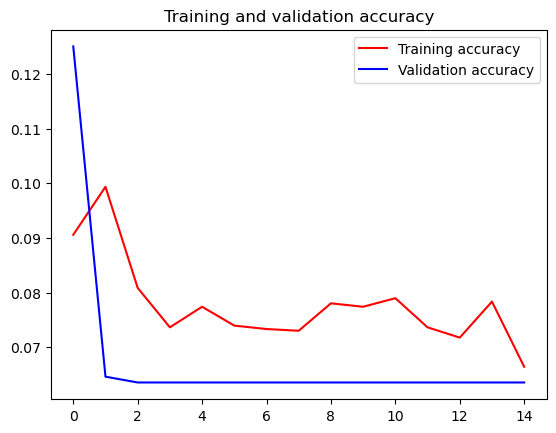

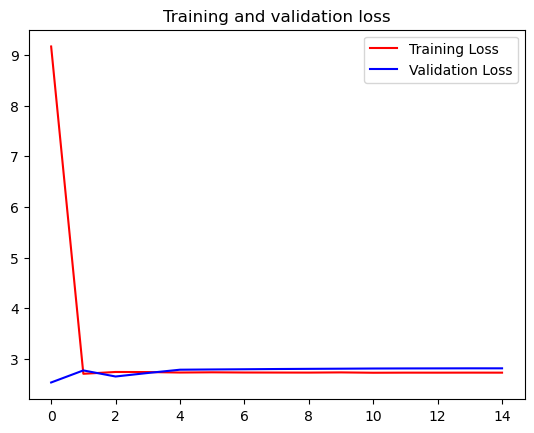

In [26]:
# Plot the chart for accuracy and loss on both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()


In [27]:
# Get the class labels and their corresponding indices
class_labels = train_generator.class_indices

# Reverse the dictionary to get the label-to-index mapping
label_to_index = {v: k for k, v in class_labels.items()}

class_names = []

# Print the labels
print("Class Labels:")
for label, index in label_to_index.items():
    print(f"Index: {index}, Label: {label}")
    class_names.append(index)

Class Labels:
Index: Aglaonema, Label: 0
Index: Aloe Vera, Label: 1
Index: Apple, Label: 2
Index: Caladium, Label: 3
Index: Calathea, Label: 4
Index: Cassava, Label: 5
Index: Cherry, Label: 6
Index: Grape, Label: 7
Index: Lili Paris, Label: 8
Index: Monstera Andansonii, Label: 9
Index: Potato, Label: 10
Index: Sansevieria, Label: 11
Index: Soybean, Label: 12
Index: Tomato, Label: 13
Index: Wheat, Label: 14
Index: sunflower, Label: 15


In [30]:

# Load the image you want to predict
image_path = "/Users/arsyaninsa/Documents/Data_Personal/Kuliah/Bangkid/Nyobas Modelling/dataset/train/Apple leaf/Apple leaf (19).jpg"
image = Image.open(image_path)
image = image.resize((150, 150))  # Resize the image to match the input size of the model

# Preprocess the image
image_array = np.array(image) / 255.0
image_array = np.expand_dims(image_array, axis=0)  # Add a batch dimension

# Make the prediction
prediction = model.predict(image_array)
predicted_class_index = np.argmax(prediction)
predicted_class = class_names[predicted_class_index]

# Print the predicted class
print("Predicted class:", predicted_class)

1/1 [==============================] - 0s 72ms/step
Predicted class: Cassava
